This notebook implement the cubic spiral optimization algorithm described in the McNaughton paper for motion planning (https://www.ri.cmu.edu/pub_files/2011/7/mcnaughton-thesis.pdf). The high level algorithm will use a simplified "shooting method" to find parameters of the cubic spiral which connect two poses (x,y, theta, kappa), where curvature (kappa) is a cubic polynomial function of travel (s).
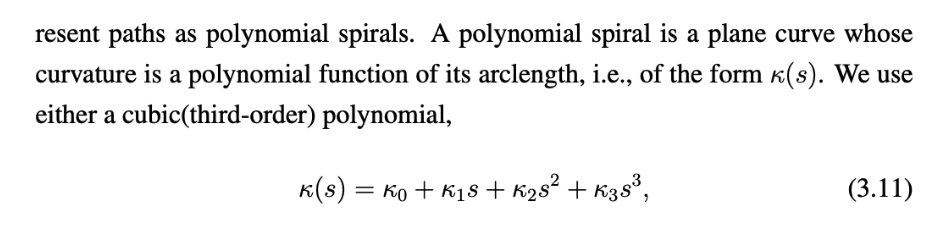

We use sympy which allows us to do symbolic mathematics in python, and numpy for numerical computations.

In [1]:
from sympy import *
import numpy

# cubic spline allows for continuous curvature
# 3.3.1 introduces cubic polynominal spirals
# 3.5 talks about stability and introducing new parameters
# 3.6 onward talks about optimization

# a,b,c,d are the coefficients of the cubic polynomial, s is the variable that represents travel along the spiral.
a,b,c,d, s = symbols("a b c d s")
kappa = a + b*s + c*s**2 + d*s**3


Following the paper, we reparameterize the problem to improve numeric stability. Kappa 0...3 can differ by orders of magnitude, so optimizing to find them can cause issues. Instead, we reparameterize the spiral with the curvature at points along the curve (p0...p3) which should be more similar to each other. Then, we can rederive the original cubic coefficients from these new parameters.
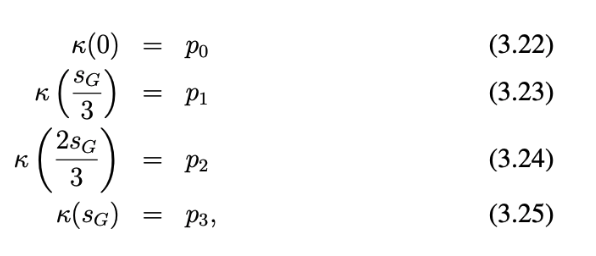
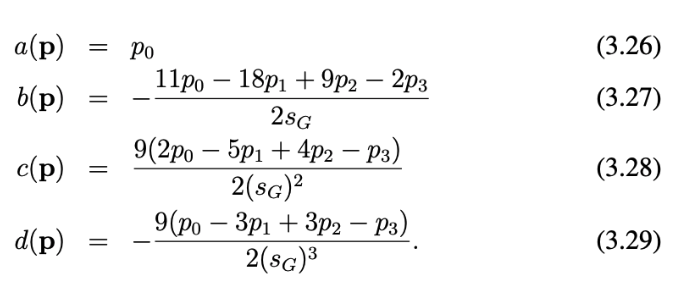

In [2]:
p0, p1, p2, p3, sG = symbols("p0 p1 p2 p3 sG")
eq1 = kappa.subs(s,0) - p0
eq2 = kappa.subs(s, sG/3) - p1
eq3 = kappa.subs(s, 2*sG/3) - p2
eq4 = kappa.subs(s, sG) - p3
sol = solve([eq1, eq2, eq3, eq4], {a, b, c, d})

In [3]:
sol # these should match up with the formulas derived in the paper (3.26-3.29)

{a: p0,
 b: (-11*p0 + 18*p1 - 9*p2 + 2*p3)/(2*sG),
 c: (18*p0 - 45*p1 + 36*p2 - 9*p3)/(2*sG**2),
 d: (-9*p0 + 27*p1 - 27*p2 + 9*p3)/(2*sG**3)}

In [4]:
a = sol[a]
b = sol[b]
c = sol[c]
d = sol[d]

Now we know we can solve for p0...3 instead of kappa0...3.
Now let's look at how we can use the p parameters to compute the configuration (and not just the curvature) at any travel. As the text states, we can assume our initial position starts at [0,0,0, kappa_I].

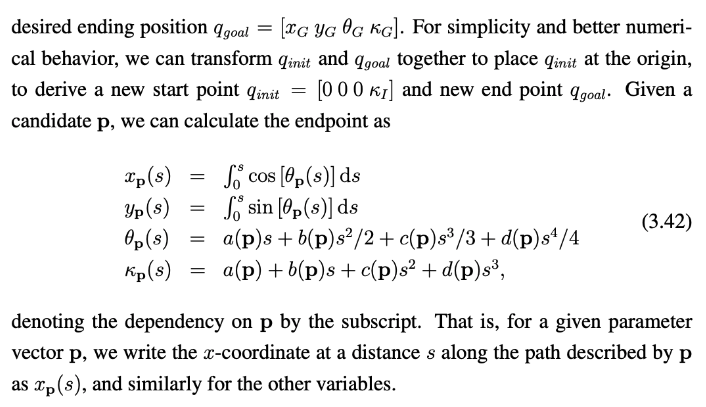



In [5]:
# if a,b,c,d are known, easy to compute theta(s) or kappa(s)
theta = a*s + b*s**2/2 + c*s**3/3 + d*s**4/4
kappa = a + b*s + c*s**2 + d*s**3

In [6]:

theta

p0*s + s**4*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/(8*sG**3) + s**3*(18*p0 - 45*p1 + 36*p2 - 9*p3)/(6*sG**2) + s**2*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/(4*sG)

In [7]:
# we can easily take deriv of theta wrt diff params (i.e sG or p1) - this will be useful later
diff(theta, sG)

-3*s**4*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/(8*sG**4) - s**3*(18*p0 - 45*p1 + 36*p2 - 9*p3)/(3*sG**3) - s**2*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/(4*sG**2)

In [8]:
# what about x or y? there is an integral in the term
# x = integrate(cos(theta),(s,0,s)) will crash sympy...

While the heading and curvature are straightforward to compute, the x and y positions do not have a closed form solution. Instead, we use "composite simpson" rule to integrate numerically.

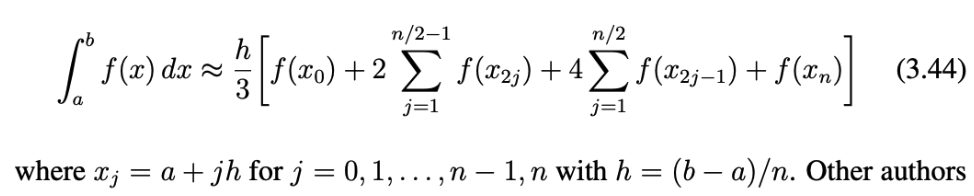

In [9]:

# returns the symbolic derivative of the composite simpson intergral of f (from 0 to sG)
# n is the number of parts to break it into, must be even.
def composite_simpson(f, sG, n=8):
    """returns the symbolic derivative of the composite simpson intergral of f (from 0 to sG).
       
       n is the number of parts to break it into, must be even."""
    h = (sG)/n
    
    exp = f.subs(s,0)
    for j in range(1, int(n/2)):
        exp += 2 * f.subs(s,2*j*sG/n)
        
    for j in range(1, int(n/2)+1):
        exp += 4 * (f.subs(s,(2*j-1)*sG/n))
    
    exp += f.subs(s,sG)
        
    exp *= (h/3.0)    
    return exp

Using the composite simpson method, we can now write down x_sG in sympy.

In [10]:

x_sG = composite_simpson(cos(theta), sG)
y_sG = composite_simpson(sin(theta), sG)

In [11]:
x_sG

0.0416666666666667*sG*(4*cos(p0*sG/8 + sG*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/256 + sG*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/32768 + sG*(18*p0 - 45*p1 + 36*p2 - 9*p3)/3072) + 2*cos(p0*sG/4 + sG*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/64 + sG*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/2048 + sG*(18*p0 - 45*p1 + 36*p2 - 9*p3)/384) + 4*cos(3*p0*sG/8 + 9*sG*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/256 + 81*sG*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/32768 + 9*sG*(18*p0 - 45*p1 + 36*p2 - 9*p3)/1024) + 2*cos(p0*sG/2 + sG*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/16 + sG*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/128 + sG*(18*p0 - 45*p1 + 36*p2 - 9*p3)/48) + 4*cos(5*p0*sG/8 + 25*sG*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/256 + 625*sG*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/32768 + 125*sG*(18*p0 - 45*p1 + 36*p2 - 9*p3)/3072) + 2*cos(3*p0*sG/4 + 9*sG*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/64 + 81*sG*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/2048 + 9*sG*(18*p0 - 45*p1 + 36*p2 - 9*p3)/128) + 4*cos(7*p0*sG/8 + 49*sG*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/256 + 2401*sG*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/32768 + 343*sG*(1

Now let's double-check our equations look correct. We'll pick a set of parameters and plot some points along the resulting cubic spiral.

In [12]:
# lets say we have some initial guess
p0_g = 0
p1_g = 0.1
p2_g = 0.2
p3_g = 0.3
sG_g = 20

p_g = (p0_g, p1_g, p2_g, p3_g, sG_g)

def eval_guess(p_g, s_eval=None):
    p0_g = p_g[0]
    p1_g = p_g[1]
    p2_g = p_g[2]
    p3_g = p_g[3]
    sG_g = p_g[4]
    if s_eval == None:
        s_eval = sG_g
    # note that i set s and sG to s_eval for x,y but sG to sG_g for theta.
    # this is not technically correct - this is because i use sG as the argument in composite simpson when it should 
    # really be s_eval. has to do with the way I'm re-using variable names in sympy
    # and i don't understand the correct way to do it.
    x_sG_g = x_sG.subs([(p0, p0_g), (p1, p1_g), (p2, p2_g), (p3, p3_g), (sG, s_eval)])
    y_sG_g = y_sG.subs([(p0, p0_g), (p1, p1_g), (p2, p2_g), (p3, p3_g), (sG, s_eval)])
    theta_sG_g = theta.subs([(p0, p0_g), (p1, p1_g), (p2, p2_g), (p3, p3_g), (s, s_eval), (sG, sG_g)])
    ka_g = kappa.subs([(p0, p0_g), (p1, p1_g), (p2, p2_g), (p3, p3_g), (s, s_eval), (sG, sG_g)])
    return x_sG_g, y_sG_g, theta_sG_g, ka_g

<class 'float'>


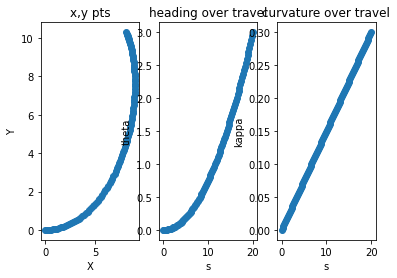

In [13]:
# let's plot it to make sure this looks right-ish?
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def plot(p_g, iteration=None, q_goal=None):
    xs = []
    ys = []
    ths = []
    kas = []
    sG_g = float(p_g[4])
    print(type(sG_g))
    ss = np.linspace(0, sG_g, 100)
    for s in ss:
        x,y,th,ka = eval_guess(p_g, s)
        xs.append(x)
        ys.append(y)
        ths.append(th)
        kas.append(ka)
    
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    iteration_str = "iteration: " + str(iteration) if iteration else ""
    fig.suptitle(iteration_str)

    ax1.set_title('x,y pts')
    ax1.plot(xs,ys, 'o')
    ax1.set(xlabel='X', ylabel='Y')
    if q_goal:
        ax1.plot(q_goal[0],q_goal[1],'r+') # plot goal x,y
    
    ax2.set_title('heading over travel')
    ax2.plot(ss, ths, 'o')
    ax2.set(xlabel='s', ylabel='theta')
    if q_goal:
        ax2.axhline(q_goal[2],color='r')

    ax3.set_title('curvature over travel')
    ax3.plot(ss, kas, 'o')
    ax3.set(xlabel='s', ylabel='kappa')
    if q_goal:
        ax3.axhline(q_goal[3], color='r')
    
    plt.show()

plot(p_g)

This looks about right - the curvature is continuous, matches the specified values at different travels and the x,y, heading look continuous. Next let's look at how we can compute the jacobian of the function mapping parameters to endpoint.

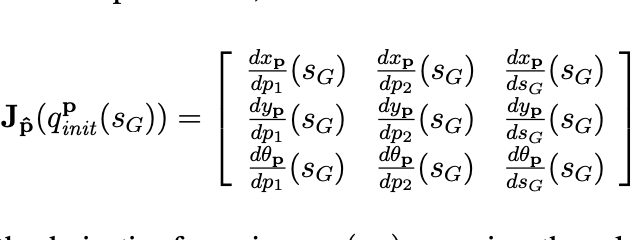

Here, the Jacobian specifies the derivative of different outputs with respect to different inputs. p0 and p3 are skipped as inputs, since they are fixed once the end state is known (p0 is equal to initial curvature and p3 is equal to final curvature). For the same reason, kappa is also omitted as an output. This leaves 3 input parameters and 3 output parameters.

In [14]:
def Jacobian(p_g):
    p0_g = p_g[0]
    p1_g = p_g[1]
    p2_g = p_g[2]
    p3_g = p_g[3]
    sG_g = p_g[4]
    
    substitutions = [(p0, p0_g), (p1, p1_g), (p2, p2_g), (p3, p3_g), (sG, sG_g), (s, sG_g)]
    
    J11 = diff(x_sG, p1).subs(substitutions)
    J12 = diff(x_sG, p2).subs(substitutions)
    J13 = diff(x_sG, sG).subs(substitutions)
    J21 = diff(y_sG, p1).subs(substitutions)
    J22 = diff(y_sG, p2).subs(substitutions)
    J23 = diff(y_sG, sG).subs(substitutions)
    J31 = diff(theta, p1).subs(substitutions)
    J32 = diff(theta, p2).subs(substitutions)
    J33 = diff(theta, sG).subs(substitutions)
    J = Matrix([[J11,J12,J13], [J21,J22, J33], [J31,J32,J33]])
    
    return J

In [15]:
J = Jacobian(p_g)

In [16]:
shape(J)

(3, 3)

In [17]:
J_inv = J.inv()
J_inv

Matrix([
[-0.00878537524132703, 0.00992612890400282, 0.00717839658074327],
[-0.00406632118472299, -0.0240348582398757,   0.031951707824863],
[  -0.642584821302501,  -0.705436466793644,   -4.71016144638635]])

Now we have all the pieces we need to do the full Newton's method:
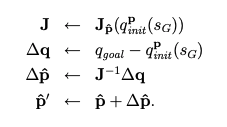

In [18]:
import math
# k_i = 0.2
# k_goal = 1.0

k_i = 0.0
k_goal = 0.2
x_goal = 10.0
y_goal = 5.0


# initial point is (0,0,0,kappa_i)
q_i = Matrix([0.0, 0.0, 0.0, k_i])
# destination point is (10,20,pi/4,0.2)
q_goal = Matrix([x_goal, y_goal, 0.0, k_goal])


# lets say we have some initial guess (p0 must match initial curvature, p3 must match actual final curvature)
p0_g = k_i
p1_g = 0.0
p2_g = 0.0
p3_g = k_goal
sG_g = 15.0

p_g = Matrix([p0_g, p1_g, p2_g, p3_g, sG_g])

intermediates = []

num_iters = 10
for i in range(0,num_iters+1):

    J = Jacobian(p_g)
    #pprint(J)
    q_sG_g = Matrix(list(eval_guess(p_g)))
    #print("q_sG_g", q_sG_g)
    d_q = q_goal - q_sG_g
    d_q.row_del(3) # delete the curvature, since we don't include it in the jacobian
    
    d_p = J.inv() * d_q 
    #print("d_p:", d_p)

    # add back 0s for p0 and p3 index (0 and 3)
    d_p = d_p.row_insert(0, Matrix([0]))
    d_p = d_p.row_insert(3, Matrix([0]))
    
    #print("d_p:", d_p)
    #print(d_p.shape)
    p_g += d_p
    if i == 3 or i == 7:
        intermediates.append((p_g, i))

intermediates.append((p_g, num_iters))
print("final ps:", p_g)    
eval_guess(p_g)


final ps: Matrix([[0], [0.179749098336037], [-0.247038077524759], [0.200000000000000], [11.9181828929782]])


(9.99986981345695, 4.98669898930157, -0.00278131292041905, 0.199999999999998)

<class 'float'>


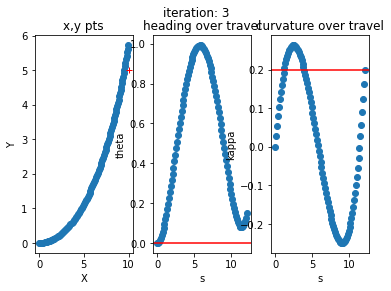

<class 'float'>


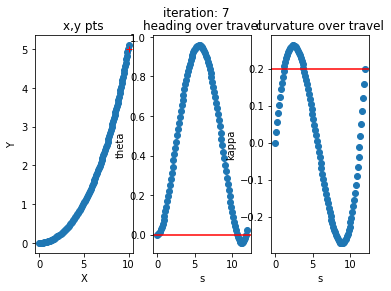

<class 'float'>


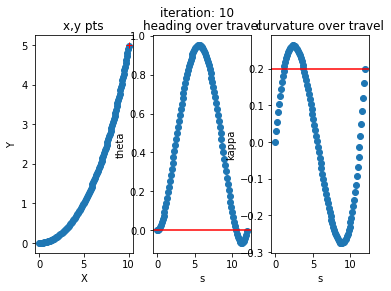

In [19]:
# plot intermediate results
for guess, i in intermediates:
    plot(guess, i, q_goal)

# Conclusion

We implemented from scratch the algorithm for finding the cubic spiral which can connect two arbitrary robot poses. This is very useful in practice, and is used in the McNaughton paper to connect "lattice points" on a grid.

# Appendix

Did not implement the initial guess algorithm, but its described here.

## Initial guess algorithm
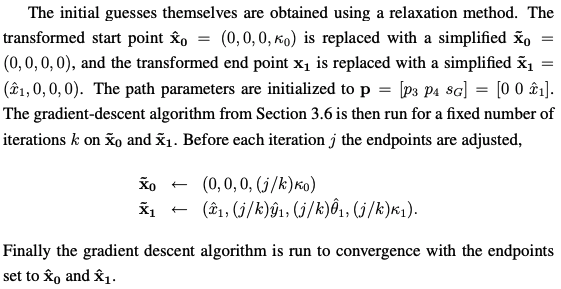